In [132]:
from sympy import symbols, Symbol, diff, sqrt, nsolve
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpmath import mp
from PIL import Image
import io
import math
import pandas as pd
import os

mp.dps = 50

In [133]:
# ---- Symbols ----
D1_sym, D2_sym = symbols('D1, D2')
x_int_sym = Symbol("x_int")
S1_sym, S2_sym = symbols('S1, S2')
Kd1_sym, Kr1_sym = symbols('Kd1, Kr1')
Kd2_sym, Kr2_sym = symbols('Kd2, Kr2')
a1_sym, a2_sym, b1_sym, b2_sym = symbols('a1, a2, b1, b2')
x_L_sym = Symbol('L')
x_sym = Symbol("x")
P_sym = Symbol("P")

# Linear solutions
u1_expr = a1_sym*x_sym + b1_sym
u2_expr = a2_sym*x_sym + b2_sym

In [134]:
def build_equations(params):
    equations = [
        u1_expr.subs(x_sym, x_int_sym)/S1_sym - u2_expr.subs(x_sym, x_int_sym)/S2_sym,
        D1_sym*diff(u1_expr, x_sym).subs(x_sym, x_int_sym) - D2_sym*diff(u2_expr, x_sym).subs(x_sym, x_int_sym),
        diff(u1_expr, x_sym).subs(x_sym, 0.0) - Kd1_sym*P_sym + Kr1_sym*u1_expr.subs(x_sym, 0.0)**2,
        diff(u1_expr, x_sym).subs(x_sym, x_L_sym) - Kr2_sym*u2_expr.subs(x_sym, x_L_sym)**2
    ]
    return [eq.subs(params) for eq in equations]

def make_params(D1, D2, Kd1, Kd2, Kr1, Kr2, x0=0.0, xint=0.5, xL=1.0, P=1e5):
    S1 = float(np.sqrt(Kd1 / Kr1))
    S2 = float(np.sqrt(Kd2 / Kr2))
    return {
        D1_sym: float(D1),
        D2_sym: float(D2),
        x_int_sym: float(xint),
        x_L_sym: float(xL),
        "x_0": float(x0),
        "x_int": float(xint),
        "x_L": float(xL),
        P_sym: float(P),
        Kd1_sym: float(Kd1),
        Kr1_sym: float(Kr1),
        Kd2_sym: float(Kd2),
        Kr2_sym: float(Kr2),
        S1_sym: float(S1),
        S2_sym: float(S2),
    }

def solve_coeffs(params, init_guess=(1.0, 1.0, 1.0, 1.0)):
    sol = nsolve(build_equations(params), [a1_sym, a2_sym, b1_sym, b2_sym], init_guess)
    return tuple(float(s) for s in sol)

def generate_profiles(coeffs, params, npts=200):
    a1, a2, b1, b2 = coeffs
    x0 = params["x_0"]; xint = params["x_int"]; xL = params["x_L"]
    x1 = np.linspace(x0, xint, npts); x2 = np.linspace(xint, xL, npts)
    u1 = a1*x1 + b1; u2 = a2*x2 + b2
    return x1, u1, x2, u2

def calc_W_R(params):
    x0 = params["x_0"]; xint = params["x_int"]; xL = params["x_L"]
    D1 = params[D1_sym]; D2 = params[D2_sym]
    Kd1 = params[Kd1_sym]; Kd2 = params[Kd2_sym]
    P = params[P_sym]; S1 = params[S1_sym]; S2 = params[S2_sym]
    W = Kd1 * (P**0.5) * ((xint - x0)/(D1*S1) + (xL - xint)/(D2*S2))
    R = Kd2 / Kd1
    return float(W), float(R), float(W*R)

def plot_single(res, title=None):
    fig = plt.figure(figsize=(6, 3.8))
    ax = fig.gca()
    ax.plot(res["x1"], res["u1"], label="u₁(x)")
    ax.plot(res["x2"], res["u2"], label="u₂(x)")
    ax.axvline(res["params"]["x_int"], linestyle="--", label="$x_{int}$")
    txt = f"W = {res['W']:.2e}\nR = {res['R']:.2e}\nW·R = {res['WR']:.2e}"
    ax.text(0.98, 0.98, txt, ha="right", va="top", transform=ax.transAxes,
            bbox=dict(boxstyle="round,pad=0.3", alpha=0.15))
    ax.set_xlabel("x"); ax.set_ylabel("u(x)"); ax.grid(True); ax.legend(loc="best")
    if title:
        fig.suptitle(title, y=1.02)
    fig.tight_layout()
    return fig

In [135]:

import sympy as sp
from itertools import product
from mpmath import mp

unknowns = [a1_sym, a2_sym, b1_sym, b2_sym]

def _try_linear_solve(params):
    # Build equations symbolically, then extract matrix form A*coef = rhs
    eqs = build_equations(params)
    M, rhs = sp.linear_eq_to_matrix(eqs, unknowns)  # works iff linear in unknowns
    # Substitute numbers and solve with LU; handle near-singularity via least squares
    M_num = sp.Matrix(M.subs(params)).evalf()   # numeric matrix
    rhs_num = sp.Matrix(rhs.subs(params)).evalf()
    try:
        if M_num.rank() == M_num.shape[0]:
            sol = M_num.LUsolve(rhs_num)
            return tuple(float(s) for s in sol)
        else:
            # Least-squares fallback if nearly singular
            sol = (M_num.T*M_num).LUsolve(M_num.T*rhs_num)
            return tuple(float(s) for s in sol)
    except Exception:
        return None

def _norm_residual(eqs, vals):
    subd = {u:v for u,v in zip(unknowns, vals)}
    res = [abs(complex(sp.N(eq.subs(subd)))) for eq in eqs]
    return max(res)

def solve_coeffs(params,
                 init_guess=(1.0, 1.0, 1.0, 1.0),
                 warm_start=None):
    """
    Robust solver for (a1, a2, b1, b2).
    1) Try direct linear solve (fast, no initial guess).
    2) If that fails / non-linear, try multi-start nsolve with scaling.
    """
    # 1) Linear solve path (most common)
    lin_sol = _try_linear_solve(params)
    if lin_sol is not None and all(sp.Float(str(v)).is_finite for v in lin_sol):
        return lin_sol

    # 2) Nonlinear or failed: resilient nsolve
    eqs = build_equations(params)
    vars_ = unknowns
    mp.dps = max(mp.dps, 80)  # increase precision for tough cases

    # Compose a small pool of starts: warm start (from previous nearby params), user init, and scale sweep
    starts = []
    if warm_start is not None:
        starts.append(tuple(float(x) for x in warm_start))
    starts.append(tuple(float(x) for x in init_guess))

    # Add a few magnitude sweeps to cover huge W/R ranges
    magnitudes = (1e-9, 1e-6, 1e-3, 1.0, 1e3, 1e6, 1e9)
    for m in (1e-6, 1.0, 1e6):  # keep it small to avoid combinatorial blow-up
        starts.append((m, m, m, m))
        starts.append((1/m, 1/m, 1/m, 1/m))

    # Light sign diversity
    starts.append((1.0, -1.0, 1.0, -1.0))
    starts.append((-1.0, 1.0, -1.0, 1.0))

    best_sol, best_res = None, float('inf')
    for g in starts:
        try:
            sol = sp.nsolve(
                eqs, vars_, g,
                tol=1e-30, maxsteps=200, prec=mp.dps
            )
            sol = tuple(float(s) for s in sol)
            res = _norm_residual(eqs, sol)
            if res < best_res:
                best_res, best_sol = res, sol
                if res < 1e-20:
                    break
        except Exception:
            continue

    if best_sol is None:
        # As a last resort, scale variables to improve conditioning and retry
        s = 1.0
        # crude heuristic: scale based on |x_L| if present
        if "x_L" in params and abs(float(params["x_L"])) > 0:
            s = 1.0 / max(1.0, abs(float(params["x_L"])))
        a1s, a2s, b1s, b2s = [sp.Symbol(str(v)+"_s") for v in unknowns]
        subs_scale = {a1_sym: a1s/s, a2_sym: a2s/s, b1_sym: b1s, b2_sym: b2s}
        eqs_s = [sp.simplify(eq.subs(subs_scale)) for eq in eqs]
        try:
            sol_s = sp.nsolve(eqs_s, [a1s, a2s, b1s, b2s], (1,1,1,1),
                              tol=1e-30, maxsteps=200, prec=mp.dps)
            sol = (float(sol_s[0]/s), float(sol_s[1]/s), float(sol_s[2]), float(sol_s[3]))
            return sol
        except Exception as e:
            raise ValueError(
                "Could not find root within tolerance after robust attempts. "
                "Try different params or check conditioning."
            ) from e

    return best_sol

In [136]:
# ---- LINSPACE RANGES (simple, around given baselines) ----
# Kd_max, Kd_min = 1, 10
# Kr_max, Kr_min = 1, 10
# D_max, D_min   = 1, 10

Kd_max, Kd_min = 8e12, 3e11 # 3e16, 8e9
Kr_max, Kr_min = 2.68e-20, 2.4e-38
D_max, D_min   = 6e-7, 3e-10 # 6e-7, 1.54e-15

range_size = 2

D1_vals = np.linspace(D_min, D_max, 2)
D2_vals = np.linspace(D_min, D_max, 2)
Kd1_vals = np.linspace(Kd_min, Kd_max, range_size)
Kd2_vals = np.linspace(Kd_min, Kd_max, range_size)
Kr1_vals = np.linspace(Kr_min, Kr_max, 2)
Kr2_vals = np.linspace(Kr_min, Kr_max, 2)

In [137]:
from itertools import product
import numpy as np
from typing import List, Iterable, Sequence

def all_coeff_combinations(
    a: Sequence, b: Sequence, c: Sequence, d: Sequence, e: Sequence, f: Sequence
) -> List[List]:
    """
    Return all combinations (cartesian product) of six input arrays as a list of lists.

    Each inner list has length 6, containing one element from each input.
    Works with numpy arrays, lists, tuples, etc.

    Note: The output size is len(a)*len(b)*len(c)*len(d)*len(e)*len(f).
    """
    return [list(t) for t in product(a, b, c, d, e, f)]

all_combs = all_coeff_combinations(D1_vals, D2_vals, Kd1_vals, Kd2_vals, Kr1_vals, Kr2_vals)
# print(len(all_combs), all_combs)

In [138]:
results = []
for params_list in all_combs:
    D1, D2, Kd1, Kd2, Kr1, Kr2 = params_list
    params = make_params(D1, D2, Kd1, Kd2, Kr1, Kr2)

    coeffs = solve_coeffs(params)
    # x1,u1,x2,u2 = generate_profiles(coeffs, params)
    W,R,WR = calc_W_R(params)

    results.append({
        "params": params, "coeffs": coeffs,
        "W": W, "R": R, "WR": WR
    })

NonlinearError: nonlinear term: b1**2

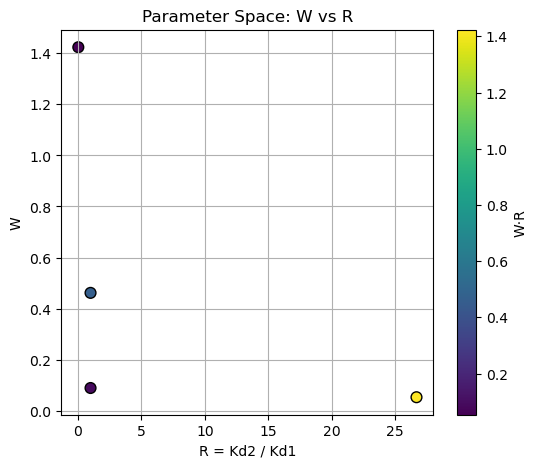

In [ ]:
# Use results from the last linspace exploration (already built in previous cell)
if not results:
    print("No results to plot.")
else:
    # Build DataFrame
    records = []
    for res in results:
        p = res["params"]
        records.append({
            "W": res["W"],
            "R": res["R"],
            "WR": res["WR"],
            "Kd1": p[Kd1_sym],
            "Kd2": p[Kd2_sym],
            "Kr1": p[Kr1_sym],
            "Kr2": p[Kr2_sym],
            "D1": p[D1_sym],
            "D2": p[D2_sym],
            "x_0": p["x_0"],
            "x_int": p["x_int"],
            "x_L": p["x_L"],
            "a1": res["coeffs"][0],
            "a2": res["coeffs"][1],
            "b1": res["coeffs"][2],
            "b2": res["coeffs"][3],
        })
    df = pd.DataFrame.from_records(records)
    
    # Scatter plot
    plt.figure(figsize=(6,5))
    plt.scatter(df["R"], df["W"], c=df["WR"], cmap="viridis", s=60, edgecolor="k")
    plt.xlabel("R = Kd2 / Kd1")
    plt.ylabel("W")
    plt.title("Parameter Space: W vs R")
    cbar = plt.colorbar(label="W·R")
    plt.grid(True)
    plt.show()


In [ ]:
# Use current working directory as "parent"
parent_dir = os.getcwd()

# Make a "figures" folder if it doesn't exist
figures_dir = os.path.join(parent_dir, "figures")
os.makedirs(figures_dir, exist_ok=True)

# Save inside that folder
csv_path = os.path.join(figures_dir, "W_vs_R_parameter_map.csv")
df.to_csv(csv_path, index=False)

print(f"Saved parameter mapping to {csv_path}")

Saved parameter mapping to /Users/colinweaver/Documents/PTTEP/permeation_barriers/analytical_studies/colin/figures/W_vs_R_parameter_map.csv


In [ ]:
def generate_profiles(
    csv_path: str,
    row_index: int = 0,
    w_target: float = None,
    r_target: float = None,
    decade_tol: float = None,   # e.g., 0.3 decades ≈ within ~2x
    n1: int = 200,
    n2: int = 200,
):
    """
    Load coefficients/params from CSV and prepare arrays for plotting u1 and u2.
    Selection prefers nearest match in log10-space for W and/or R.

    Returns:
        x1_vals, u1_vals, x2_vals, u2_vals, params(dict)
    """
    df = pd.read_csv(csv_path)
    if df.empty:
        raise ValueError("CSV has no rows.")

    # Helper: robust log10 that handles zeros/tiny values
    _EPS = 1e-300
    def _log10_safe(x):
        x = np.asarray(x, dtype=float)
        return np.log10(np.maximum(x, _EPS))

    # --- Row selection ---
    sel = None
    have_W = "W" in df.columns
    have_R = "R" in df.columns

    if (w_target is not None or r_target is not None) and (have_W or have_R):
        idx_all = np.arange(len(df))
        mask_valid = np.ones(len(df), dtype=bool)

        # Exclude non-positive when a target is provided (log undefined)
        if w_target is not None and have_W:
            mask_valid &= (df["W"].values > 0)
        if r_target is not None and have_R:
            mask_valid &= (df["R"].values > 0)

        cand = idx_all[mask_valid]
        if cand.size == 0:
            # Fallback: ignore validity mask if everything is nonpositive
            cand = idx_all

        # Build distance in log space
        dist = np.zeros(cand.size, dtype=float)

        if w_target is not None and have_W:
            wlog = _log10_safe(df.loc[cand, "W"].values)
            wtlog = _log10_safe(w_target)
            dw = np.abs(wlog - wtlog)
            dist += dw**2
        if r_target is not None and have_R:
            rlog = _log10_safe(df.loc[cand, "R"].values)
            rtlog = _log10_safe(r_target)
            dr = np.abs(rlog - rtlog)
            dist += dr**2

        # Optional tolerance filter in decades (apply component-wise if both provided)
        if decade_tol is not None:
            keep = np.ones_like(dist, dtype=bool)
            if w_target is not None and have_W:
                keep &= (np.abs(_log10_safe(df.loc[cand, "W"].values) - _log10_safe(w_target)) <= decade_tol)
            if r_target is not None and have_R:
                keep &= (np.abs(_log10_safe(df.loc[cand, "R"].values) - _log10_safe(r_target)) <= decade_tol)
            if np.any(keep):
                cand = cand[keep]
                dist = dist[keep]

        sel = int(cand[np.argmin(dist)]) if cand.size else row_index

    if sel is None:
        sel = row_index

    row = df.loc[sel]

    # --- Extract required coefficients and geometry (from CSV) ---
    try:
        a1 = float(row["a1"]); a2 = float(row["a2"])
        b1 = float(row["b1"]); b2 = float(row["b2"])
        x_0 = float(row["x_0"]); x_int = float(row["x_int"]); x_L = float(row["x_L"])
    except KeyError as e:
        raise KeyError(f"Missing column in CSV: {e}. Expected a1,a2,b1,b2,x_0,x_int,x_L.")

    # --- Build grids and evaluate piecewise linear solutions ---
    x1_vals = np.linspace(x_0, x_int, n1)
    x2_vals = np.linspace(x_int, x_L, n2)
    u1_vals = a1 * x1_vals + b1
    u2_vals = a2 * x2_vals + b2

    # Boundary checks
    print(f"C1 = {u1_vals[0]}")
    print(f"C2 = {u2_vals[-1]}")

    # Params for downstream
    params = {
        "a1": a1, "a2": a2, "b1": b1, "b2": b2,
        "x_0": x_0, "x_int": x_int, "x_L": x_L,
    }

    # Copy over useful columns if present
    for key in ["W", "R", "WR", "Kd1", "Kd2", "Kr1", "Kr2", "D1", "D2", "S1", "S2", "P"]:
        if key in row:
            try:
                params[key] = float(row[key])
            except Exception:
                pass

    # Print W, R, W*R when available
    if "W" in params and "R" in params:
        print(f"W = {params['W']} \nR = {params['R']}\nW*R = {params['W']*params['R']}")
    print("Diffusion limited")

    return x1_vals, u1_vals, x2_vals, u2_vals, params

C1 = 2.125575754577921e+26
C2 = 1.0976425999001244e+27
W = 0.0533816135878401 
R = 26.666666666666668
W*R = 1.423509695675736
Diffusion limited


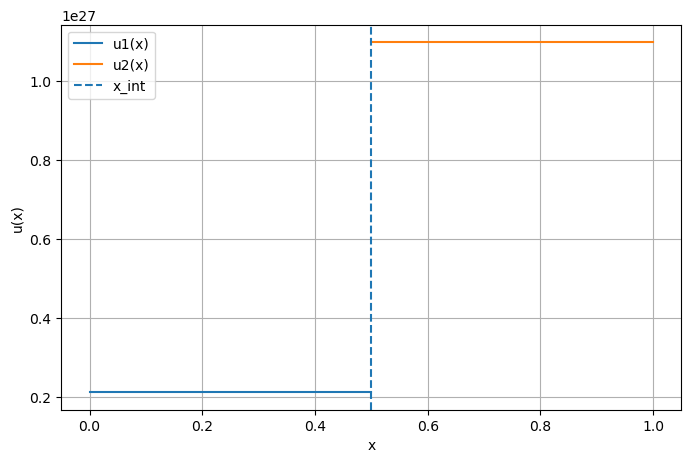

In [ ]:
# choose the row whose (W,R) is nearest to (1e-6, 1e4) in log10-space,
# and require each to be within ±0.5 decades (~3.16×), if such a row exists
x1_vals, u1_vals, x2_vals, u2_vals, params = generate_profiles(
    csv_path,
    # row_index=1,
    w_target=1e-6,
    r_target=1e4,
    decade_tol=0.5,
    n1=200,
    n2=200,
)

# plotting (same as before)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(x1_vals, u1_vals, label="u1(x)")
plt.plot(x2_vals, u2_vals, label="u2(x)")
plt.axvline(params["x_int"], linestyle="--", label="x_int")
plt.xlabel("x"); plt.ylabel("u(x)")
plt.legend(); plt.grid(); plt.show()